In [74]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer
from scalar_features import ScalarFeaturizer
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [5]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPE'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'

In [6]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [7]:
n_groups = [[0,1,2], [3,4,5,6,7]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)

In [8]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')

In [9]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)

### Get x center info

In [10]:
sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_com')

# first [0] is pos, second [0] is first particle
#pos_part0 = [halo.load_positions_and_velocities()[0][0] for halo in sim_reader.dark_halo_arr]
x_coms  = [halo.catalog_properties['x_com'] for halo in sim_reader.dark_halo_arr]
x_minPEs  = [halo.catalog_properties['x_minPE'] for halo in sim_reader.dark_halo_arr]

x_coms_shifted = np.array([sim_reader.dark_halo_arr[i].shift_points_torus(x_coms[i], x_minPEs[i]) for i in range(len(sim_reader.dark_halo_arr))])
x_minPEs_shifted = np.array([sim_reader.dark_halo_arr[i].shift_points_torus(x_minPEs[i], x_minPEs[i]) for i in range(len(sim_reader.dark_halo_arr))])

delta_x_norm = np.linalg.norm(x_coms_shifted - x_minPEs_shifted, axis=1)
#delta_x_norm = np.delete(delta_x_norm, idxs_nan_structure_catalog, axis=0)

sim_reader.add_catalog_property_to_halos('r200m')
r_200m = [halo.catalog_properties['r200m'] for halo in sim_reader.dark_halo_arr]
delta_x_norm_perr200m = delta_x_norm/r_200m

### Two bins (inner/outer), with eigenvalues, with rescaling + MXV vals

In [91]:
m_order_max = 1
x_order_max = 0
v_order_max = 0
eigenvalues_not_trace = True

In [92]:
print("hi")

hi


In [93]:
scalar_featurizer_rescaled = ScalarFeaturizer(geo_feature_arr_rebinned)
scalar_featurizer_rescaled.compute_MXV_from_features()
scalar_featurizer_rescaled.rescale_geometric_features(scalar_featurizer_rescaled.M_tot, 
                                             scalar_featurizer_rescaled.X_rms, 
                                             scalar_featurizer_rescaled.V_rms)

In [94]:
import time

In [101]:
s = time.time()
scalar_featurizer_rescaled.featurize(m_order_max, x_order_max=x_order_max, 
                                     v_order_max=v_order_max,
                                     eigenvalues_not_trace=eigenvalues_not_trace)
e = time.time()
print('time:', e-s)

time: 3.259047746658325


In [ ]:
names = [f.name for f in scalar_featurizer_rescaled.scalar_feature_arr[0]]

In [ ]:
# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((scalar_featurizer_rescaled.M_tot, 
                              scalar_featurizer_rescaled.X_rms,
                              scalar_featurizer_rescaled.V_rms)).T
x_features_extra = np.log10(x_features_extra)   

In [88]:
names = [f.name for f in scalar_featurizer_rescaled.scalar_feature_arr[0]]
for name in names:
    print(name)

g_000
g_001


In [52]:
for name in names:
    if 'A' in name:
        print(name)

[A(g_110)]_jk [A(g_110)]_jk
[A(g_110)]_jk [A(g_110)]_jk [g_110]_jk [g_110]_jk
[A(g_110)]_jk [A(g_110)]_jk e3(g_110)
[A(g_110)]_jk [A(g_110)]_jk e2(g_110)
[A(g_110)]_jk [A(g_110)]_jk e1(g_110)
[A(g_110)]_jk [A(g_111)]_jk
[A(g_110)]_jk [A(g_111)]_jk [g_110]_jk [g_111]_jk
[A(g_110)]_jk [A(g_111)]_jk e3(g_110)
[A(g_110)]_jk [A(g_111)]_jk e2(g_110)
[A(g_110)]_jk [A(g_111)]_jk e1(g_110)
[A(g_110)]_jk [A(g_111)]_jk e3(g_111)
[A(g_110)]_jk [A(g_111)]_jk e2(g_111)
[A(g_110)]_jk [A(g_111)]_jk e1(g_111)
[A(g_111)]_jk [A(g_111)]_jk
[A(g_111)]_jk [A(g_111)]_jk [g_111]_jk [g_111]_jk
[A(g_111)]_jk [A(g_111)]_jk e3(g_111)
[A(g_111)]_jk [A(g_111)]_jk e2(g_111)
[A(g_111)]_jk [A(g_111)]_jk e1(g_111)


In [53]:
for name in names:
    if 'A' not in name:
        print(name)

g_000
e3(g_020)
e2(g_020)
e1(g_020)
e3(g_020) e2(g_020)
e3(g_020) e1(g_020)
e2(g_020) e1(g_020)
e3(g_110)
e2(g_110)
e1(g_110)
e3(g_110) e2(g_110)
e3(g_110) e1(g_110)
e2(g_110) e1(g_110)
e3(g_200)
e2(g_200)
e1(g_200)
e3(g_200) e2(g_200)
e3(g_200) e1(g_200)
e2(g_200) e1(g_200)
g_001
e3(g_021)
e2(g_021)
e1(g_021)
e3(g_021) e2(g_021)
e3(g_021) e1(g_021)
e2(g_021) e1(g_021)
e3(g_111)
e2(g_111)
e1(g_111)
e3(g_111) e2(g_111)
e3(g_111) e1(g_111)
e2(g_111) e1(g_111)
e3(g_201)
e2(g_201)
e1(g_201)
e3(g_201) e2(g_201)
e3(g_201) e1(g_201)
e2(g_201) e1(g_201)
g_000
g_000
e3(g_020)
e2(g_020)
e1(g_020)
g_000 e3(g_020)
g_000 e2(g_020)
g_000 e1(g_020)
e3(g_020) e2(g_020)
e3(g_020) e1(g_020)
e2(g_020) e1(g_020)
g_000
e3(g_110)
e2(g_110)
e1(g_110)
g_000 e3(g_110)
g_000 e2(g_110)
g_000 e1(g_110)
e3(g_110) e2(g_110)
e3(g_110) e1(g_110)
e2(g_110) e1(g_110)
g_000
e3(g_200)
e2(g_200)
e1(g_200)
g_000 e3(g_200)
g_000 e2(g_200)
g_000 e1(g_200)
e3(g_200) e2(g_200)
e3(g_200) e1(g_200)
e2(g_200) e1(g_200)
g_000
g_00

## Uncertainties & powerlaw

In [11]:
uncertainties_genel2019 = utils.get_uncertainties_genel2019(log_m_stellar+log_mass_shift, sim_name=sim_name)

In [12]:
# maybe a better way to do this, but just logging for now to be consistent
def broken_power_law(log_M200, N=1, log_M1=12-log_mass_shift, beta=1, gamma=1):
    return log_M200 + np.log10( 2*N/((log_M200/log_M1)**(-beta) + (log_M200/log_M1)**gamma) )

In [13]:
M1 = 12-log_mass_shift
p0 = [0.01, M1, 1.5, 0.4]
bounds = [[0]*len(p0), [np.inf]*len(p0)]
popt, _ = curve_fit(broken_power_law, log_m_200m, log_m_stellar, sigma=uncertainties_genel2019, 
                    bounds=bounds, p0=p0)
y_val_current_powerlaw_fit = broken_power_law(log_m_200m, *popt)

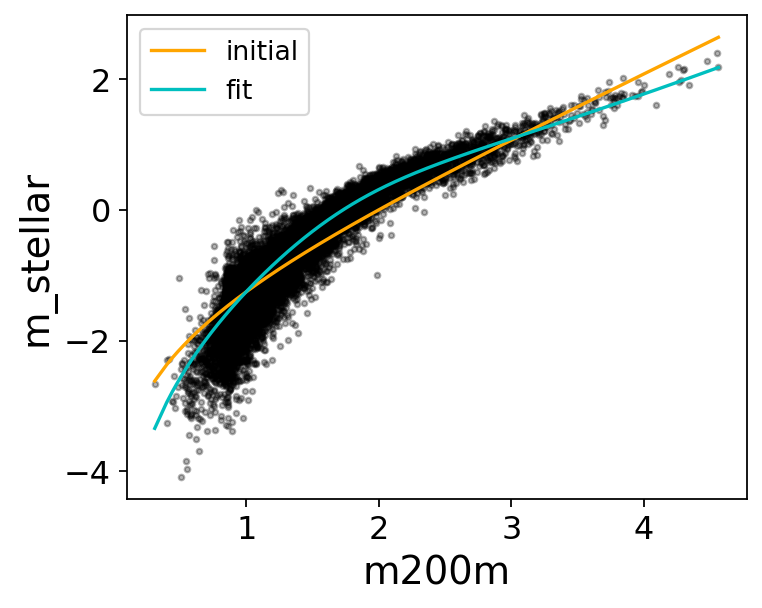

In [14]:
plt.figure(figsize=(5,4))
# sort for plotting niceness
idx_m_200m = np.argsort(log_m_200m)
y_initial = broken_power_law(log_m_200m, *p0)
plt.scatter(log_m_200m[idx_m_200m], log_m_stellar[idx_m_200m], s=6, c='k', alpha=0.3)
plt.plot(log_m_200m[idx_m_200m], y_initial[idx_m_200m], color='orange', label='initial')
plt.plot(log_m_200m[idx_m_200m], y_val_current_powerlaw_fit[idx_m_200m], color='c', label='fit')
plt.xlabel('m200m')
plt.ylabel('m_stellar')
plt.legend(fontsize=12)

### Baseline: MXV + powerlaw + const

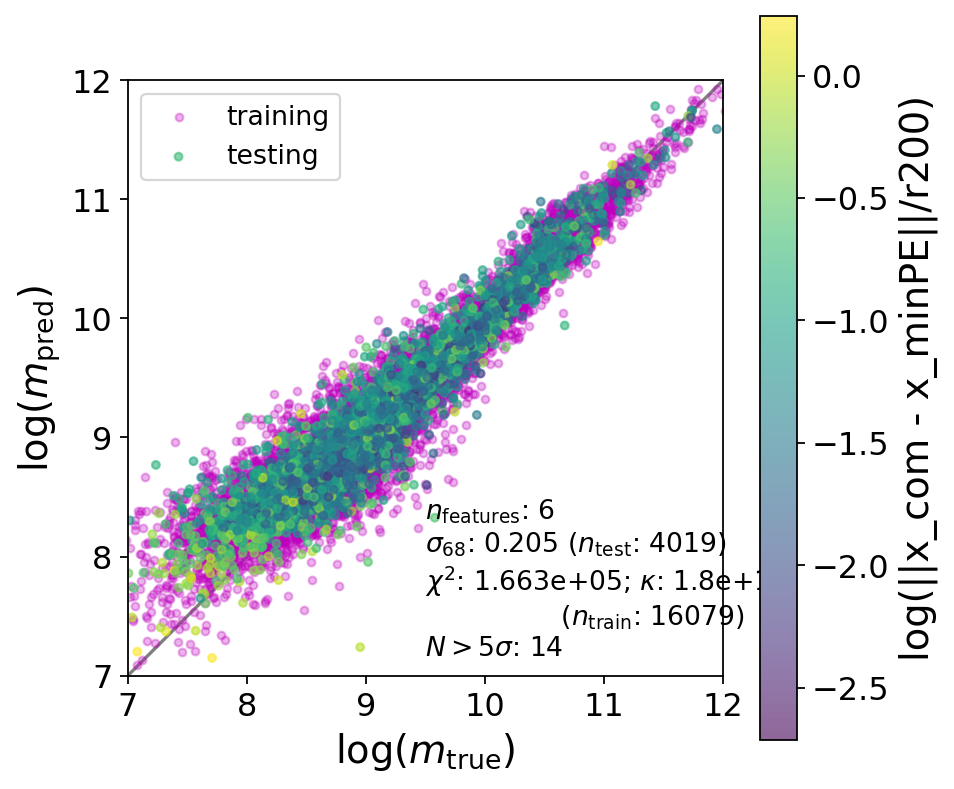

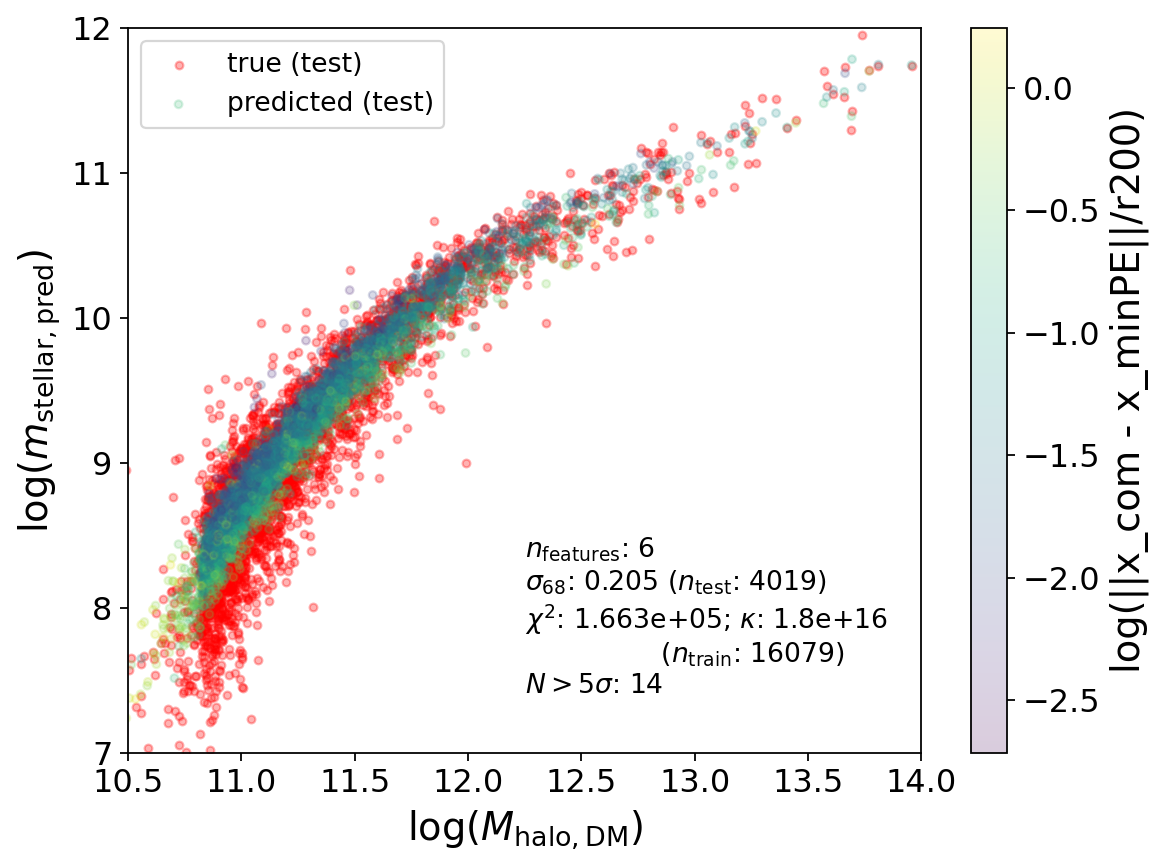

In [15]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plotter.plot_fits(fitter, log_m_200m, log_mass_shift=log_mass_shift,
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

### Full fit with scalar features: 2 bins, rescaling, MXV + powerlaw + const

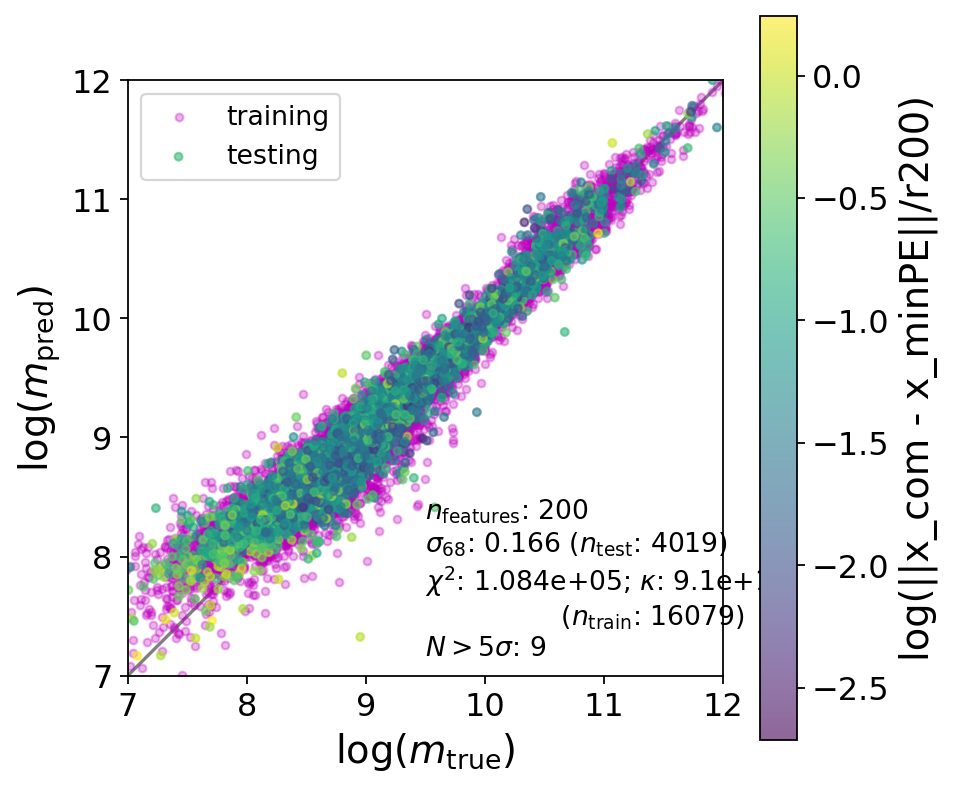

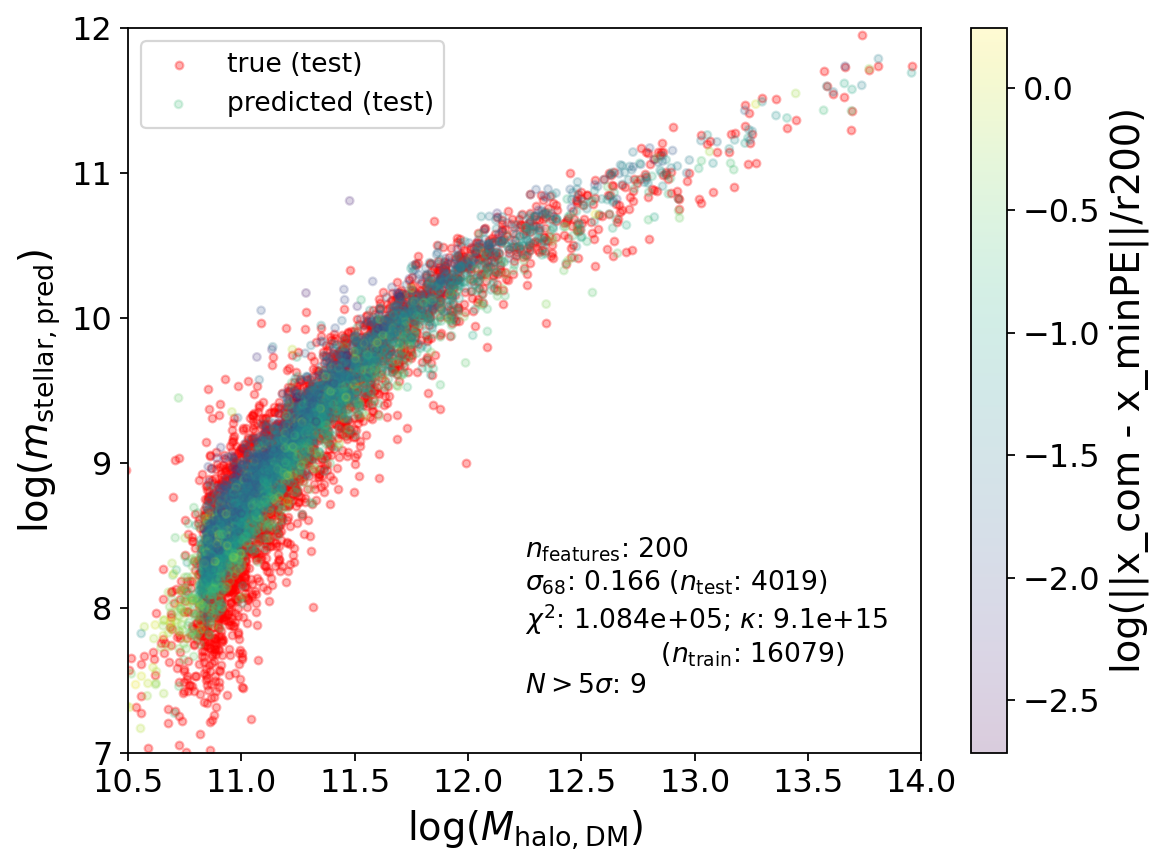

In [16]:
fitter = LinearFitter(scalar_featurizer_rescaled.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plotter.plot_fits(fitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

# Regularization

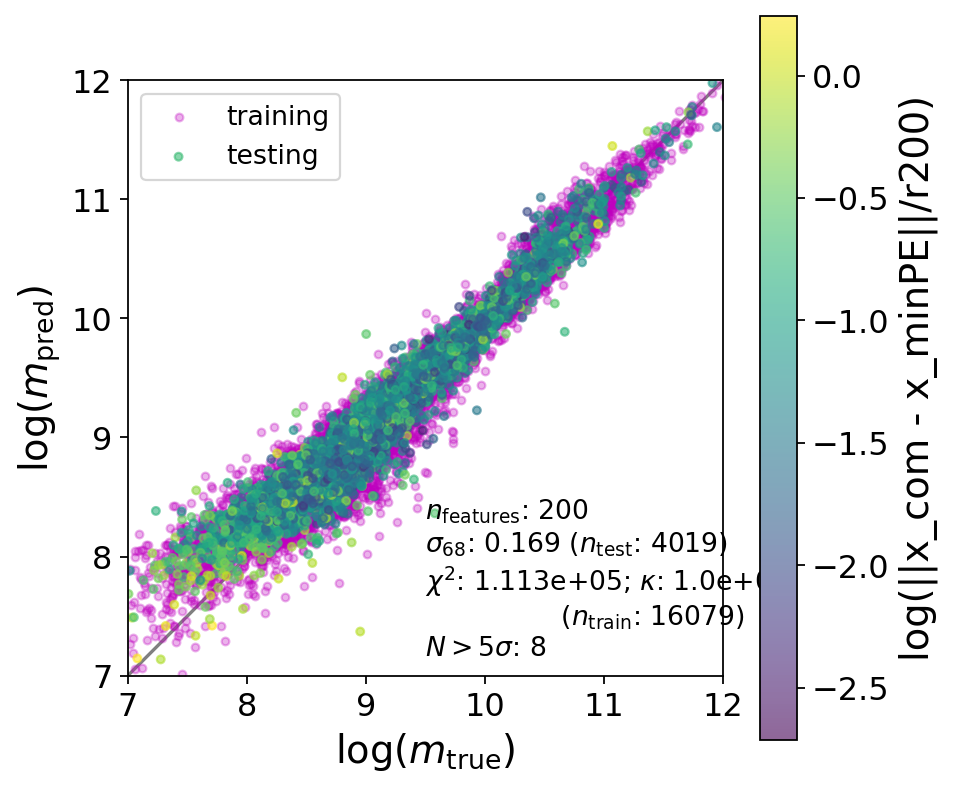

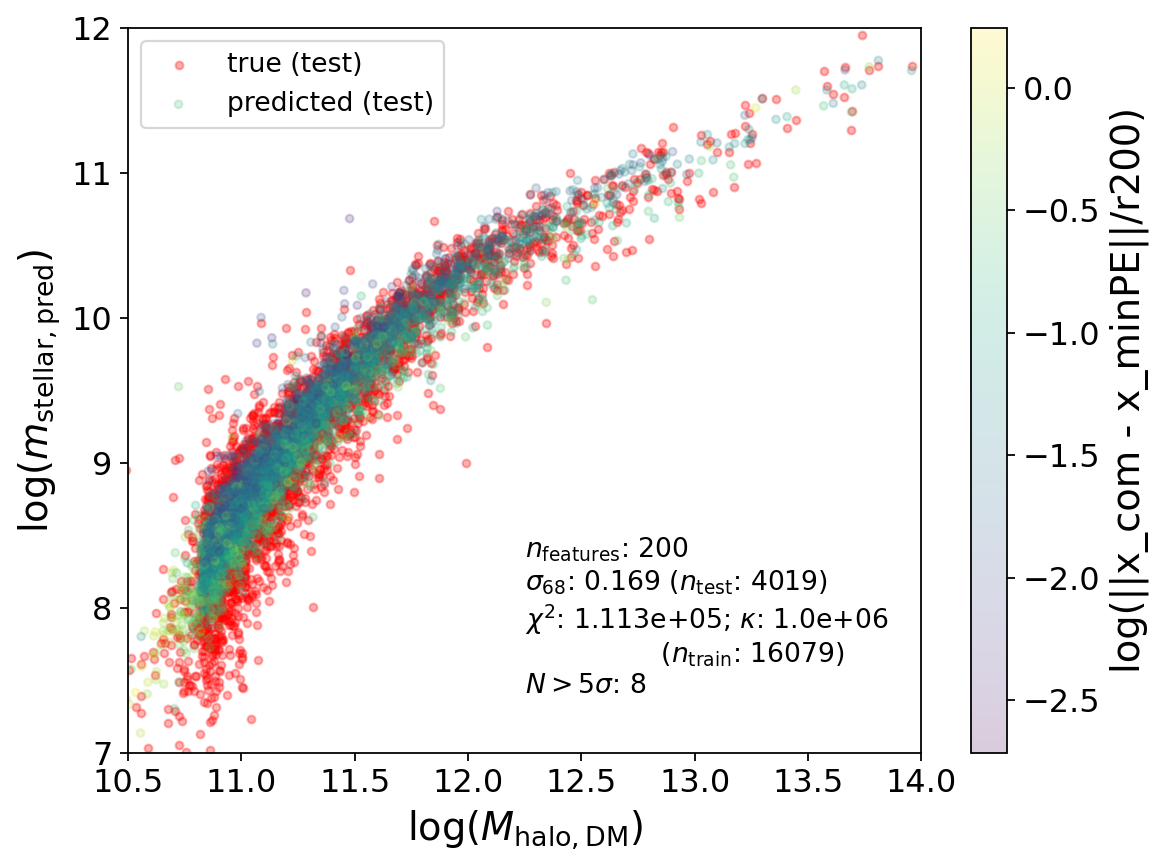

In [17]:
rfitter = LinearFitter(scalar_featurizer_rescaled.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
rfitter.split_train_test()
rfitter.scale_and_fit(rms_x=True, log_x=False, log_y=False,
                     regularization_lambda=0.0001)
rfitter.predict_test()
colors_test = np.log10(delta_x_norm_perr200m[rfitter.idx_test])
plotter.plot_fits(rfitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

# Neural net

In [18]:
nnfitter = NNFitter(scalar_featurizer_rescaled.scalar_features, log_m_stellar, 
                y_val_current_powerlaw_fit, x_features_extra=x_features_extra)
nnfitter.split_train_test()
nnfitter.set_up_data()

In [19]:
input_size = nnfitter.n_A_features
hidden_size = 32
nnfitter.model = NeuralNet(input_size, hidden_size=hidden_size)
nnfitter.train()

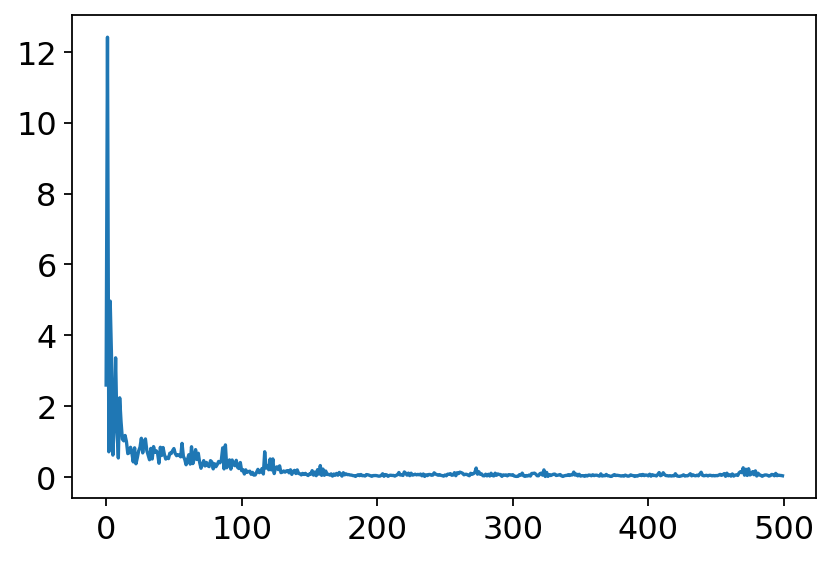

In [20]:
plt.plot(nnfitter.loss)

In [21]:
nnfitter.predict_test()

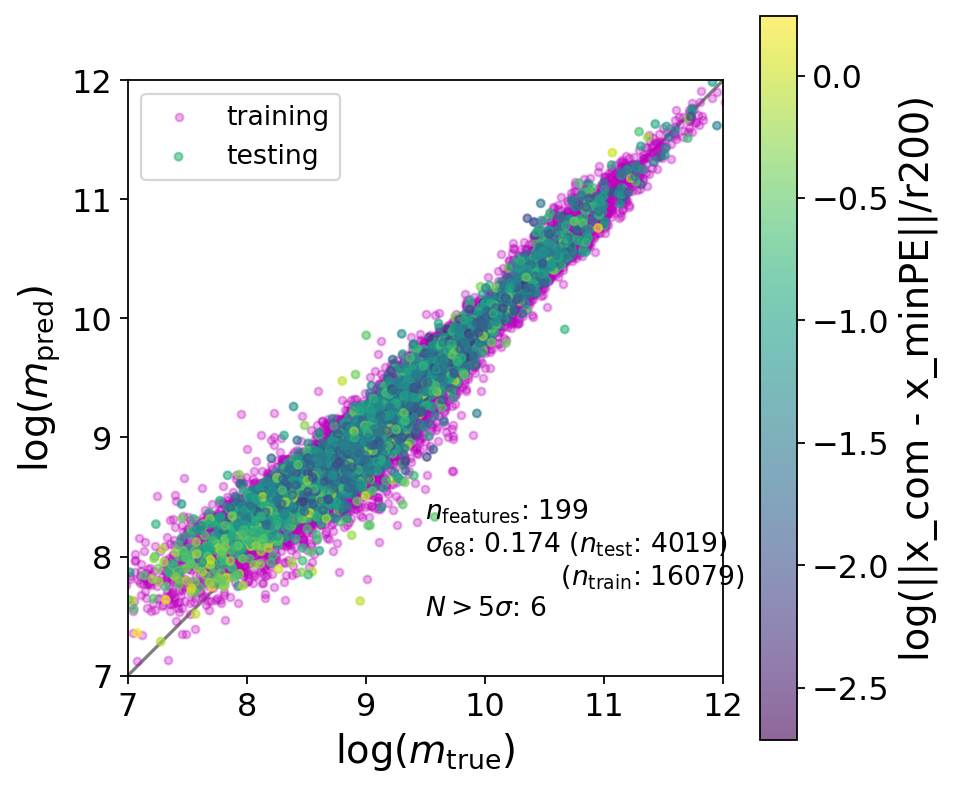

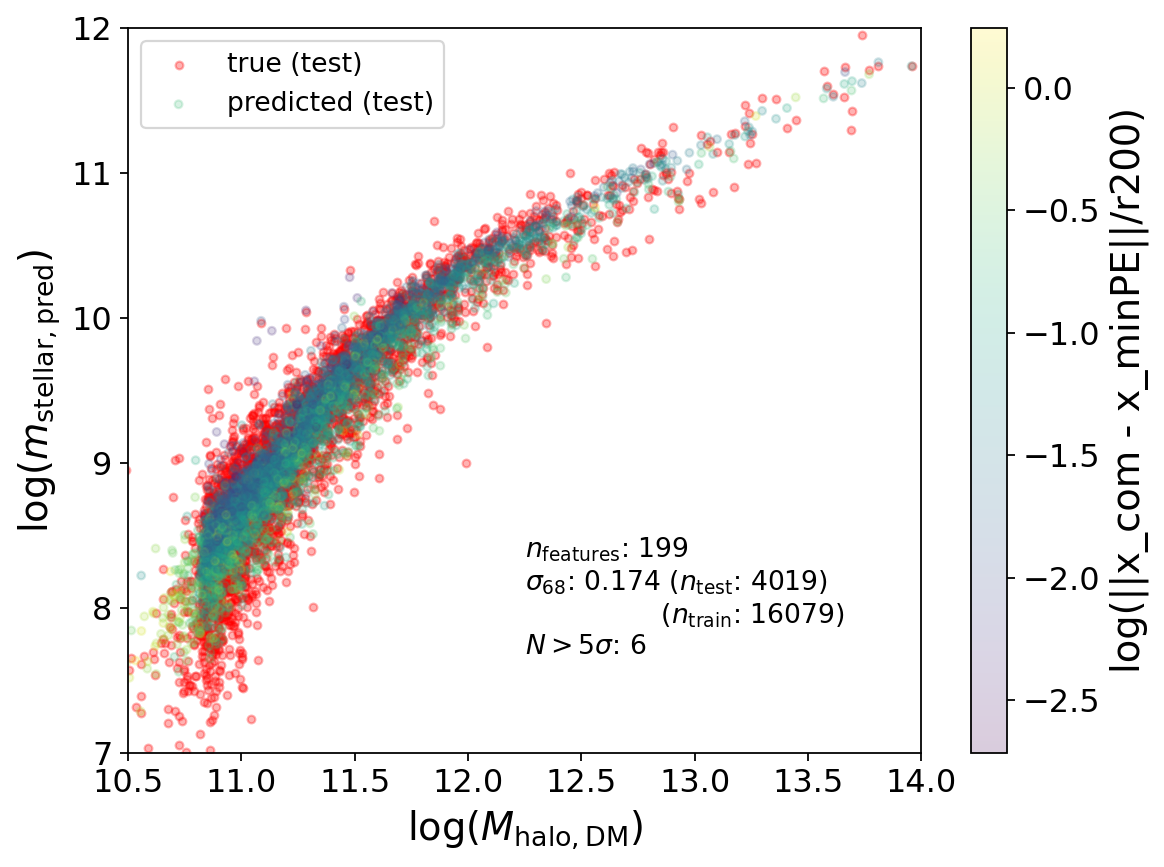

In [22]:
colors_test = np.log10(delta_x_norm_perr200m[fitter.idx_test])
plotter.plot_fits(nnfitter, log_m_200m, 
          colors_test=colors_test, colorbar_label='log(||x_com - x_minPE||/r200)')

# Feature Importance

## Coarse: mass, pos, vel, cross

In [23]:
m_order_max = 2
n_groups_rebin = [[0,1,2], [3,4,5,6,7]]
eigenvalues_not_trace = True

### mass only

In [24]:
x_order_max = 0
v_order_max = 0

scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr)
scalar_featurizer.compute_MXV_from_features()
scalar_featurizer.rescale_geometric_features(scalar_featurizer_rescaled.M_tot, 
                                             scalar_featurizer_rescaled.X_rms, 
                                             scalar_featurizer_rescaled.V_rms)
scalar_featurizer.featurize(m_order_max, x_order_max=x_order_max, 
                             v_order_max=v_order_max,
                             n_groups_rebin=n_groups_rebin,
                             eigenvalues_not_trace=eigenvalues_not_trace)

Rebinning
Rebinned to 2 bins!


In [25]:
x_features_extra = np.atleast_2d(scalar_featurizer.M_tot).T
x_features_extra = np.log10(x_features_extra)   

In [26]:
x_features_extra.shape, fitter.N_halos

((20098, 1), 20098)

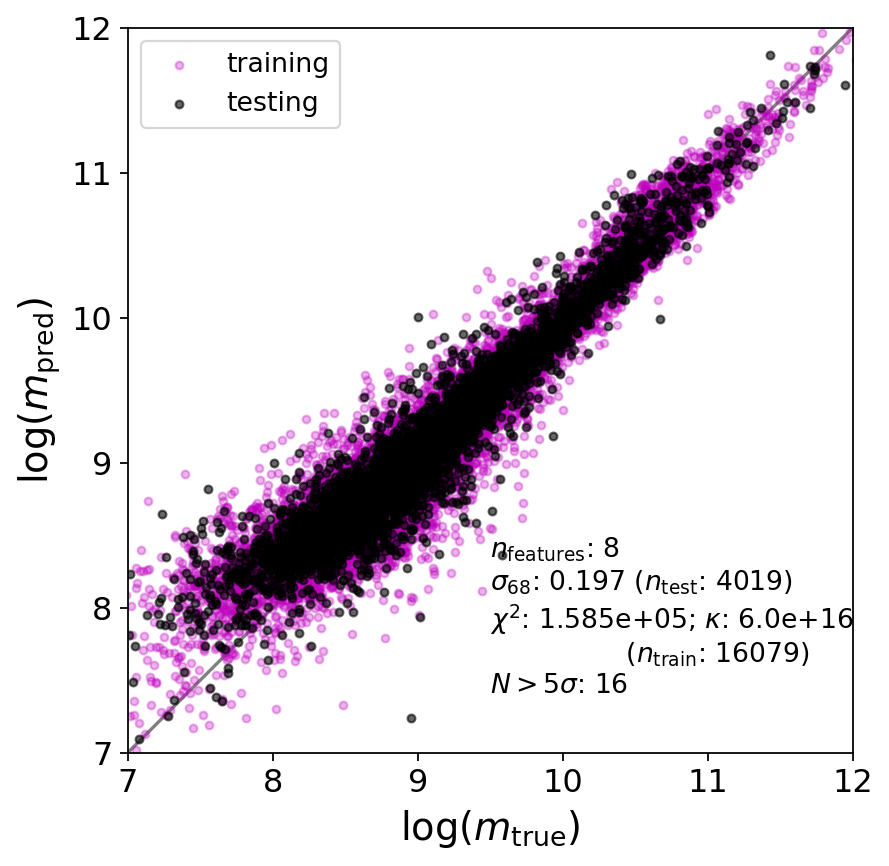

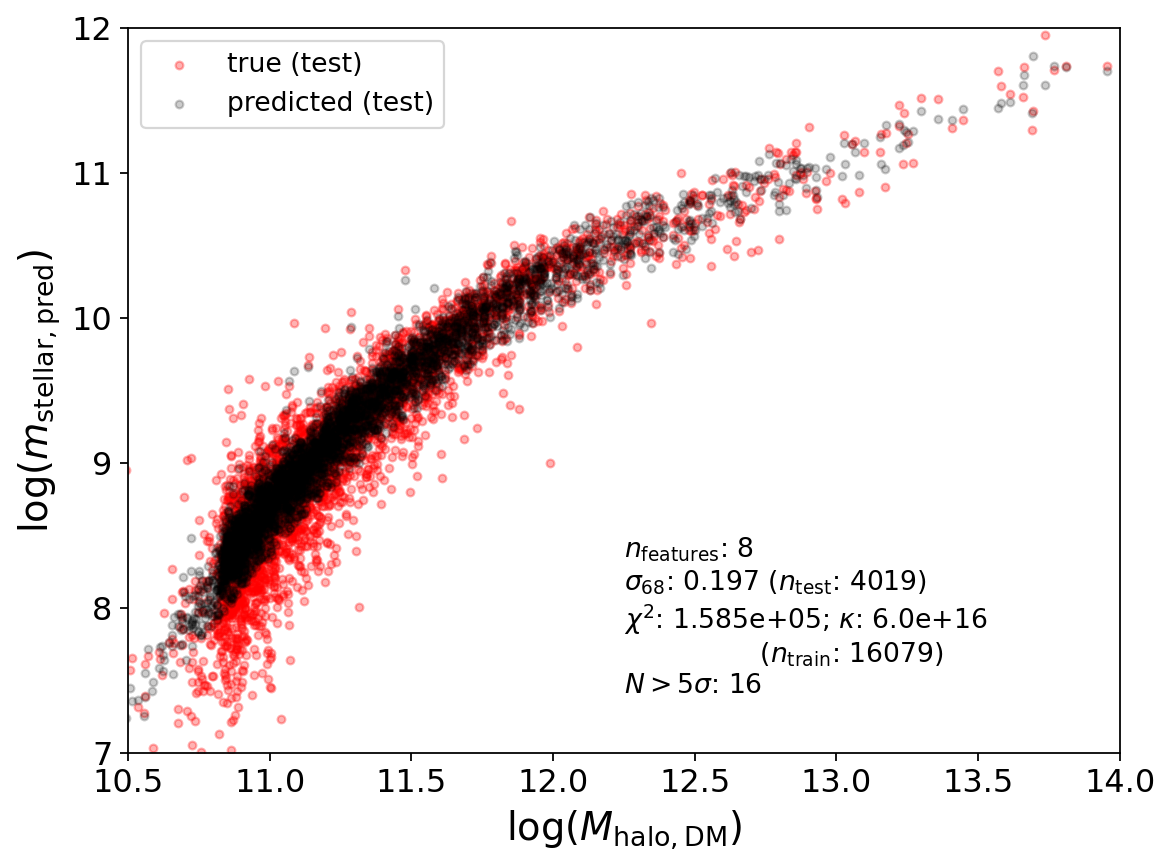

In [27]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

### mass + position

In [28]:
x_order_max = 4
v_order_max = 0

scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr)
scalar_featurizer.compute_MXV_from_features()
scalar_featurizer.rescale_geometric_features(scalar_featurizer.M_tot, 
                                             scalar_featurizer.X_rms, 
                                             scalar_featurizer.V_rms)
scalar_featurizer.featurize(m_order_max, x_order_max=x_order_max, 
                             v_order_max=v_order_max,
                             n_groups_rebin=n_groups_rebin,
                             eigenvalues_not_trace=eigenvalues_not_trace)

Rebinning
Rebinned to 2 bins!


In [29]:
x_features_extra = np.vstack((scalar_featurizer.M_tot, 
                              scalar_featurizer.X_rms)).T
x_features_extra = np.log10(x_features_extra)   

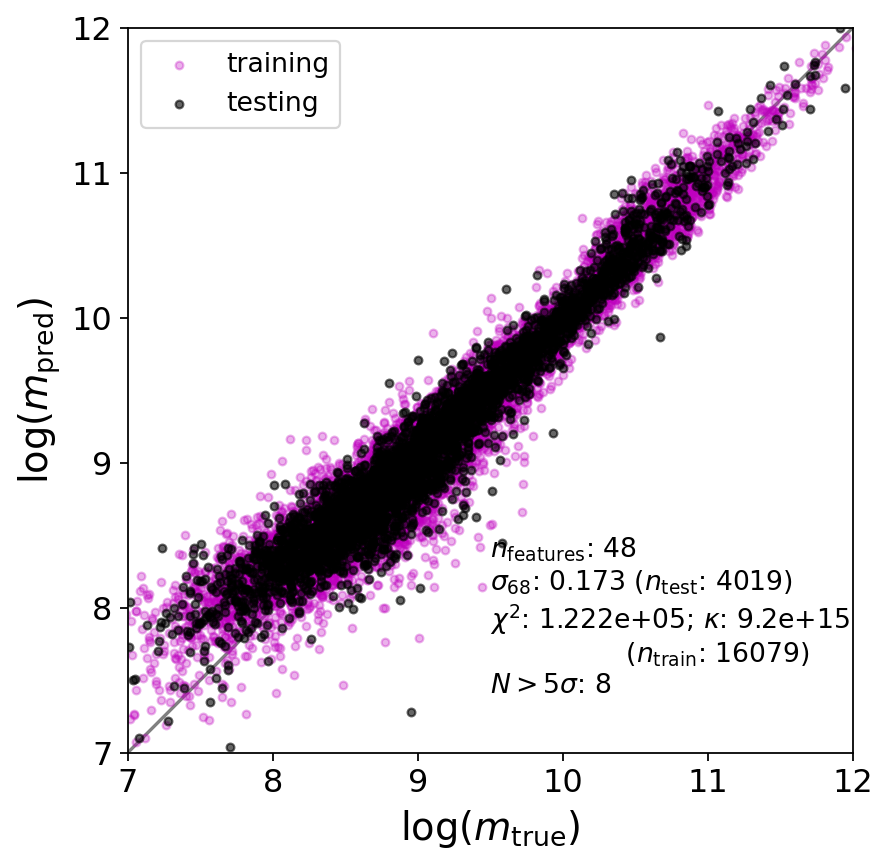

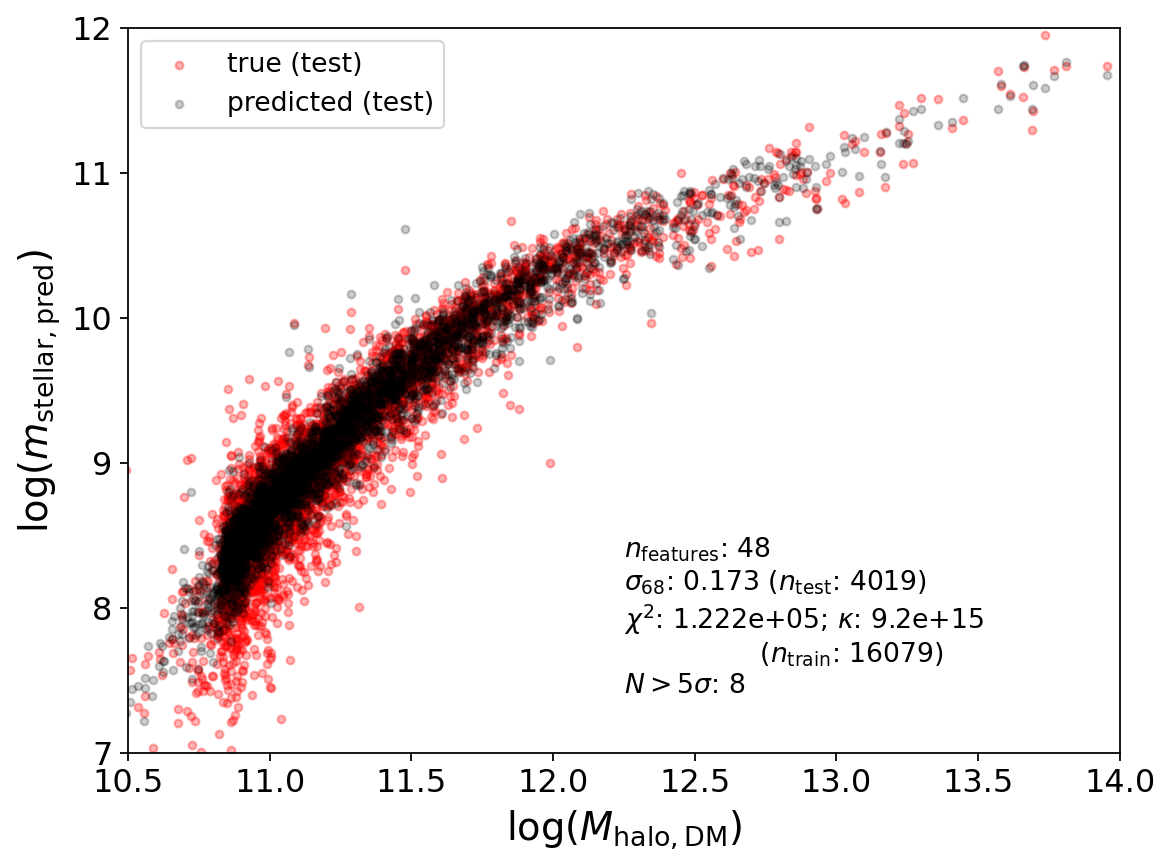

In [30]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

### mass + velocity

In [31]:
x_order_max = 0
v_order_max = 4

scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr)
scalar_featurizer.compute_MXV_from_features()
scalar_featurizer.rescale_geometric_features(scalar_featurizer.M_tot, 
                                             scalar_featurizer.X_rms, 
                                             scalar_featurizer.V_rms)
scalar_featurizer.featurize(m_order_max, x_order_max=x_order_max, 
                                     v_order_max=v_order_max,
                                     n_groups_rebin=n_groups_rebin,
                                     eigenvalues_not_trace=eigenvalues_not_trace)

Rebinning
Rebinned to 2 bins!


In [32]:
x_features_extra = np.vstack((scalar_featurizer.M_tot, 
                              scalar_featurizer.V_rms)).T
x_features_extra = np.log10(x_features_extra)   

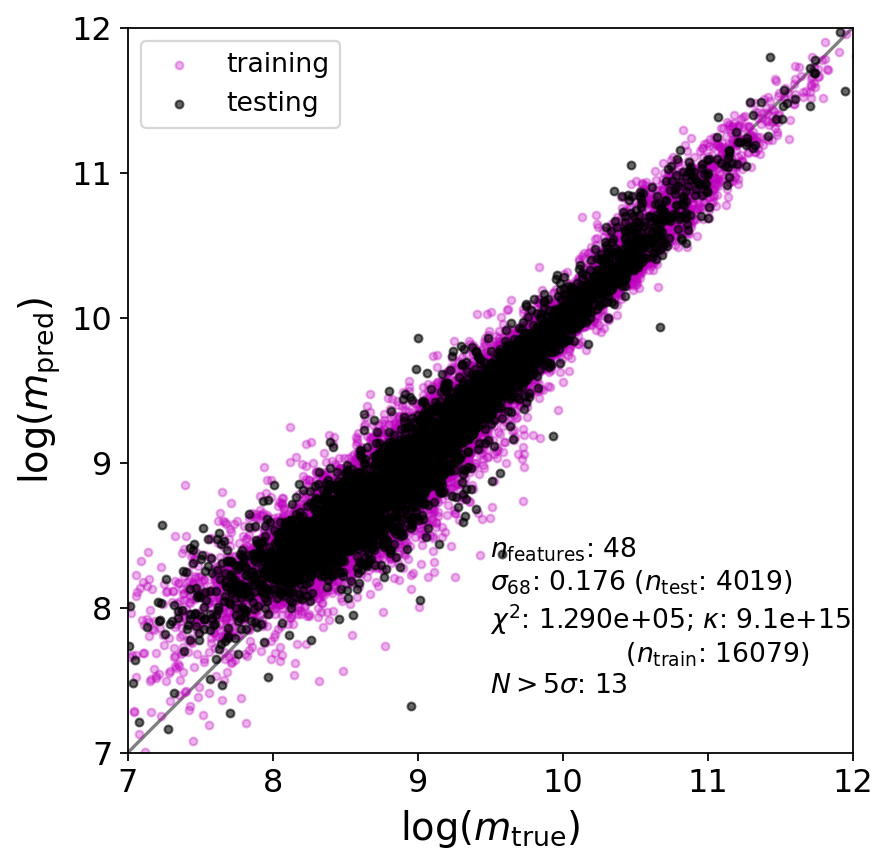

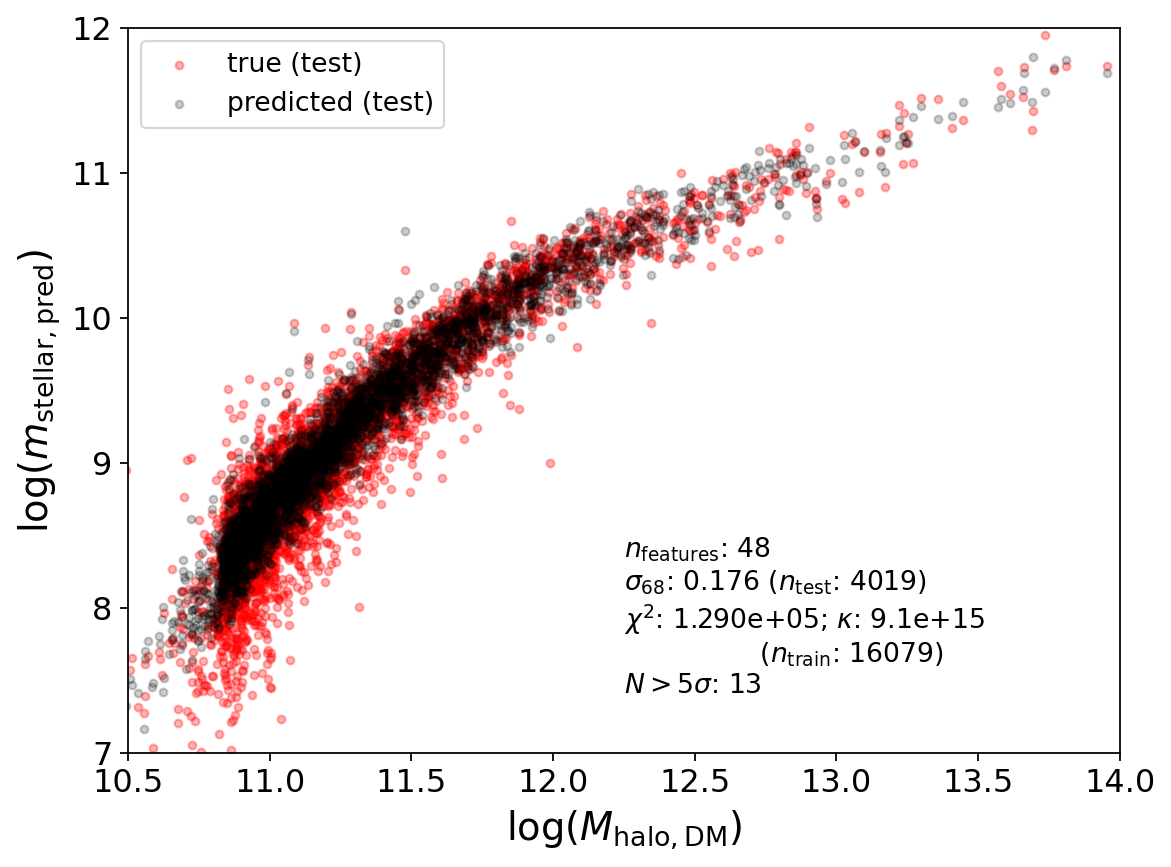

In [33]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

### mass + position + velocity

In [34]:
x_order_max = 4
v_order_max = 4

scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr)
scalar_featurizer.compute_MXV_from_features()
scalar_featurizer.rescale_geometric_features(scalar_featurizer.M_tot, 
                                             scalar_featurizer.X_rms, 
                                             scalar_featurizer.V_rms)
scalar_featurizer.featurize(m_order_max, x_order_max=x_order_max, 
                                     v_order_max=v_order_max,
                                     n_groups_rebin=n_groups_rebin,
                                     eigenvalues_not_trace=eigenvalues_not_trace)

Rebinning
Rebinned to 2 bins!


In [35]:
x_features_extra = np.vstack((scalar_featurizer.M_tot, 
                              scalar_featurizer.X_rms,
                              scalar_featurizer.V_rms)).T
x_features_extra = np.log10(x_features_extra)   

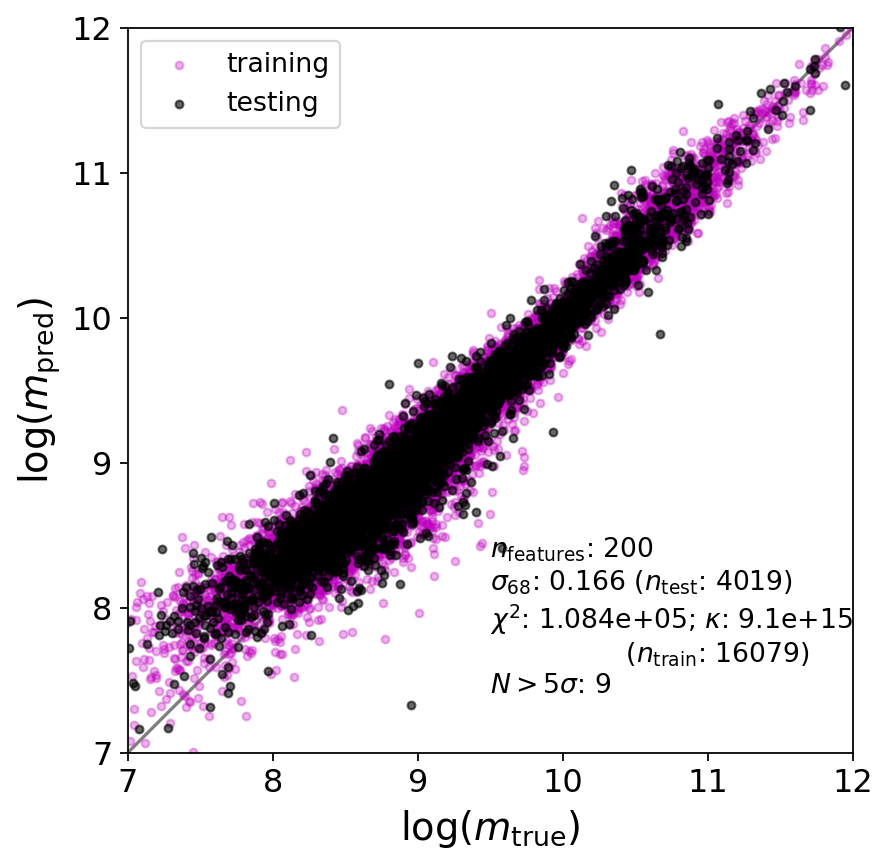

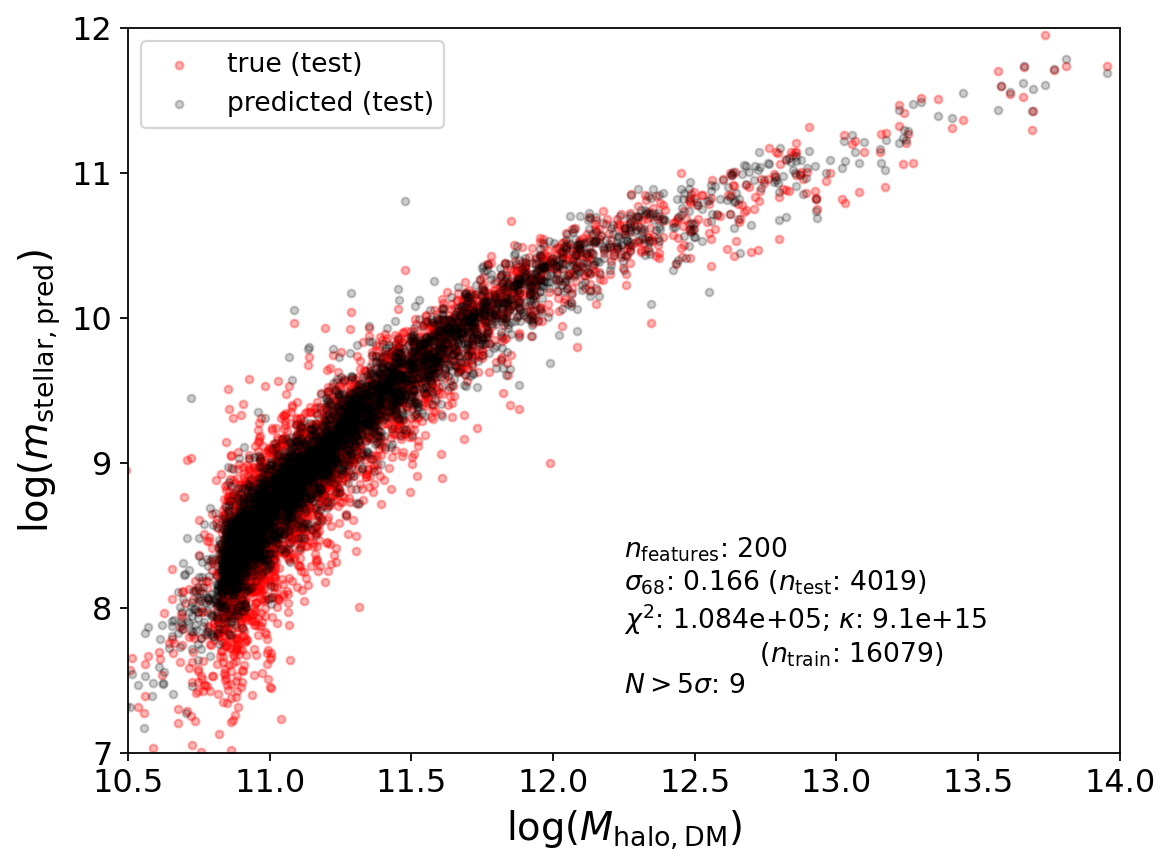

In [36]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
error_all, n_outliers_all = utils.compute_error(fitter, test_error_type='percentile')
chi2_all = fitter.chi2
plotter.plot_fits(fitter, log_m_200m)

In [37]:
N_feat = scalar_featurizer.scalar_features.shape[1]
idxs_feat = np.array(list(range(N_feat)))
errors = np.empty(N_feat)
chi2s = np.empty(N_feat)

for idx in idxs_feat:
    features = scalar_featurizer.scalar_features
    features = np.delete(features, idx, axis=1)

    fitter = LinearFitter(features, log_m_stellar, 
                        y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                        x_features_extra=x_features_extra)
    fitter.split_train_test()
    fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
    fitter.predict_test()
    
    error, n_outliers = utils.compute_error(fitter, test_error_type='percentile')
    errors[idx] = error
    chi2s[idx] = fitter.chi2

Text(0, 0.5, '$\\chi^2$')

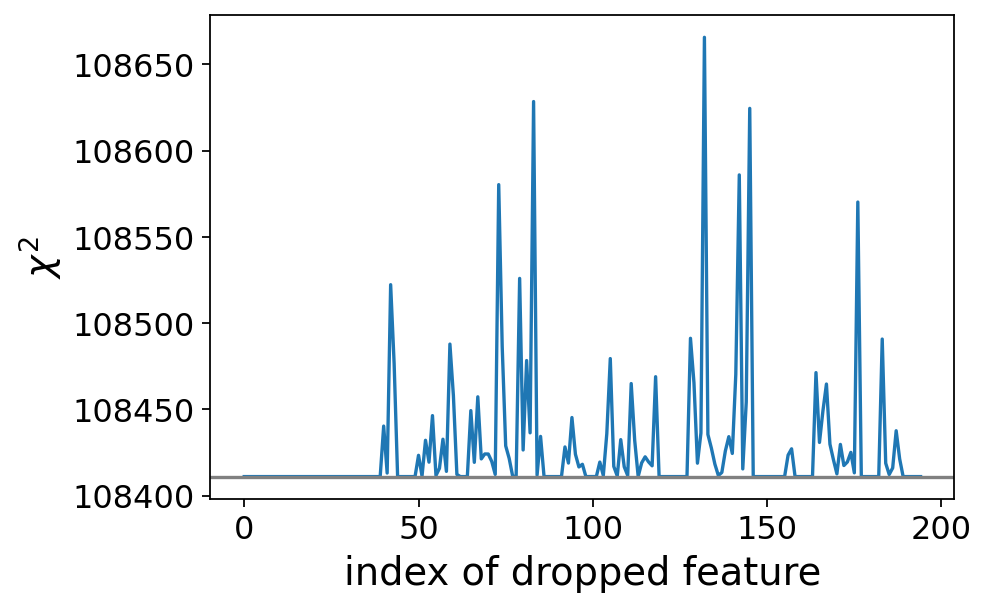

In [38]:
plt.plot(idxs_feat, chi2s)
plt.xlabel('index of dropped feature')
plt.axhline(chi2_all, color='grey', label='fit with all')
plt.ylabel('$\chi^2$')

Text(0.5, 0, 'index of dropped feature')

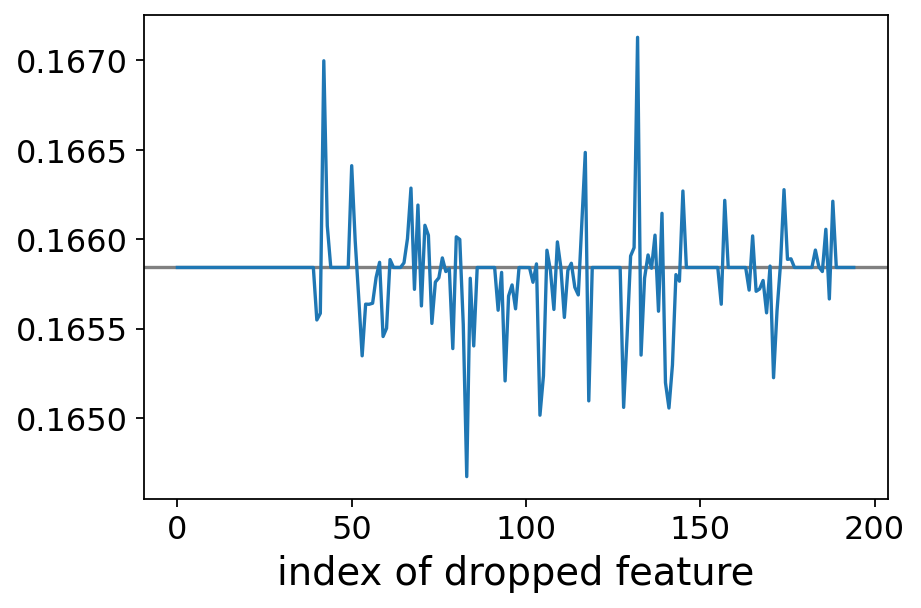

In [39]:
plt.axhline(error_all, color='grey', label='fit with all')
plt.plot(idxs_feat, errors)
plt.xlabel('index of dropped feature')

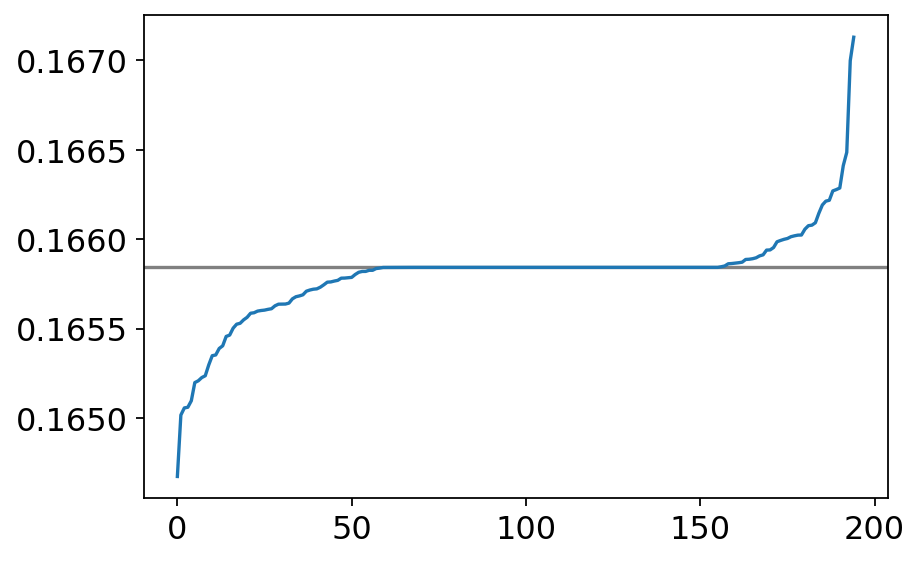

In [40]:
import scipy.stats
i_sort = np.argsort(errors)
plt.axhline(error_all, color='grey', label='fit with all')
plt.plot(errors[i_sort])
#plt.xticks(idxs_feat[i_sort])
#plt.xlabel('index of dropped feature')

In [41]:
idxs_best = idxs_feat[i_sort][::-1]

In [42]:
# 0 picks a single test sample, same features so doesn't matter which
n_print = 10
for idx_b in idxs_best[:n_print]:
    name = scalar_featurizer.scalar_feature_arr[0][idx_b].to_string()
    print(name, errors[idx_b])

AttributeError: 'ScalarFeature' object has no attribute 'name'

### Investigate features that don't change outcome when dropped

In [ ]:
idxs_flat = np.argsort(np.abs(errors - error_all))

In [ ]:
# 0 picks a single test sample, same features so doesn't matter which
for idx_f in idxs_flat[:n_print]:
    name = scalar_featurizer.scalar_feature_arr[0][idx_f].to_string()
    print(name, error)

In [ ]:
# 0 picks a single test sample, same features so doesn't matter which
idxs_matches = []
for idx_f in idxs_flat[:2]:
    feat = scalar_featurizer.scalar_features[idx_f]
    feats_other = np.delete(features, idx_f, axis=1)
    idxs_matches_per_idxflat = []
    for i in range(scalar_featurizer.scalar_features.shape[1]):
        if i==idx_f:
            continue
        if np.all_close(feat, scalar_featurizer.scalar_features[:,i]):
            idxs_matches_per_idxflat.append(i)
    idxs_matches.append(idxs_matches_per_idxflat)

In [ ]:
idx_best_top = idxs_best[:50]
fitter = LinearFitter(scalar_featurizer.scalar_features[:,idx_best_top], log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
error_all, n_outliers_all = utils.compute_error(fitter, test_error_type='percentile')
chi2_all = fitter.chi2
plotter.plot_fits(fitter, log_m_200m)

### Now let's drop one at a time starting from the worst feature!